# SAT Optics Simulation: Near-field

This notebook shows the optical path of the Simons Observatory SAT optics tube.  The ray-trace produces the electric field at the window (opening) of the SAT, which is in the near-field.  This field is convolved with a square to reproduce holography measurements, since the holography source emits its signal out of a rectangular feedhorn. 

Grace E. Chesmore
March 2022

### Optical Path
We first ray-trace from the focal plane through the 3 lenses, and out to 300mm in front of the window.  The $\verb|tele_geo.y_source|$ variable changes the plane of the rays in front of the window, since this is where the holography source will eventually scan. 

The $\verb|ray_trace.rx_to_lyot|$ outputs the amplitude and pathlength $d_{\text{PL}}$ of the rays in front of the window.  The pathlength information can be converted to phase $\phi$ due to the relationship:
$$ \phi = d_{\text{PL}} \frac{\lambda}{2\pi}$$

../sosat_optics/ot_geo.py:65: RuntimeWarning: invalid value encountered in sqrt
  amp = (c * r ** 2) / (1 + np.sqrt(1 - ((1 + k) * c ** 2 * r ** 2)))
../sosat_optics/ot_geo.py:65: RuntimeWarning: invalid value encountered in sqrt
  amp = (c * r ** 2) / (1 + np.sqrt(1 - ((1 + k) * c ** 2 * r ** 2)))
../sosat_optics/ot_geo.py:107: RuntimeWarning: invalid value encountered in sqrt
  coeff_2 = (c * 2) / (1 + np.sqrt(1 - ((1 + k) * c ** 2 * r ** 2)))
../sosat_optics/ot_geo.py:109: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1 - ((1 + k) * c ** 2 * r ** 2))
../sosat_optics/ot_geo.py:110: RuntimeWarning: invalid value encountered in sqrt
  * (1 + np.sqrt(1 - ((1 + k) * c ** 2 * r ** 2))) ** 2
../sosat_optics/ray_trace.py:12: RuntimeWarning: invalid value encountered in sqrt
  s2 = (n1 / n2) * np.cross(N_surf, (np.cross(-N_surf, s1))) - N_surf * np.sqrt(


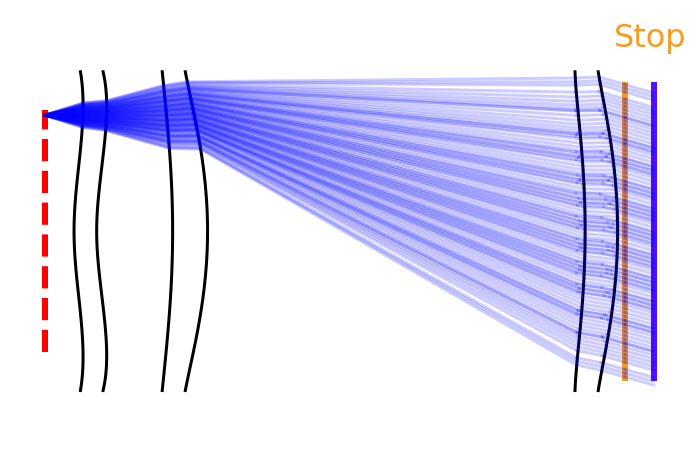

In [21]:
import numpy as np
import matplotlib
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
from scipy import interpolate

%matplotlib inline

# import sosat_optics
# from sosat_optics import ot_geo, ray_trace, opt_analyze

# %load_ext blackcellmagic

matplotlib.rcParams["font.size"] = 16
matplotlib.rcParams.update(
    {
        "axes.grid": False,
        "grid.color": "grey",
        "grid.alpha": 0.2,
        "xtick.direction": "in",
        "ytick.direction": "in",
    }
)
%config InlineBackend.figure_format = 'retina'
red = '#e42536'
blue = '#570efc'
orange = '#f89c20'

import imp
ot_geo = imp.load_source('ot_geo', '../sosat_optics/ot_geo.py')
ray_trace = imp.load_source('ray_trace', '../sosat_optics/ray_trace.py')
opt_analyze = imp.load_source('opt_analyze', '../sosat_optics/opt_analyze.py')

# Load in telescope geometry
tele_geo = ot_geo.SatGeo()
tele_geo.n_scan = 100  # sample number in 1D of 2D grid
tele_geo.y_source = (
    ot_geo.y_lyot + 40
)  # distance of holography source from SAT focal plane.
tele_geo.lambda_ = 0.002  # wavelength of source, here we choose 150GHz.
tele_geo.k = 2 * np.pi / tele_geo.lambda_  # update kappa

rx = [0, 0, 163]  # receiver feed position in focal plane
x_sim, y_sim, a_sim, p_sim = ray_trace.rx_to_lyot(rx, tele_geo, 1, "b")
# Convert pathlength to phase
p_sim = np.mod(tele_geo.k * (p_sim - np.mean(p_sim)) / 1e3 / 2, 2 * np.pi)

plt.vlines(x=ot_geo.y_lyot, ymin=-210, ymax=210, color=orange, linestyle="-",linewidth = 3)
plt.vlines(x=tele_geo.y_source, ymin=-210, ymax=210, color=blue, linestyle="-",linewidth = 3)
plt.vlines(x=0, ymin=-170, ymax=170, color="red", linestyle="--",linewidth = 3)
plt.axis('off')
plt.axis("equal")

plt.annotate("Lens 3",xy = (-50,-310))
plt.annotate("Lens 2",xy = (150,-310))
plt.annotate("Lens 1",xy = (800,-310))
plt.annotate("Stop",xy = (800,260),color = orange)
plt.annotate("Source Plane",xy = (1000,260),color = blue)
plt.annotate("Focal Plane",xy = (-50,260),color = red)
plt.show()

## Holography Measurement

We will eventually measure these fields with holography.  A rectangular feedhorn emits the signal into the optics tube, convolving the measured beam, and therefor we need to account for this convolution in our simulation. 

A convolution of the fields shows the amplitude of the beam fall off quickly at ~10cm radius from center.  The phase also remains relatively constant in front of the window. 

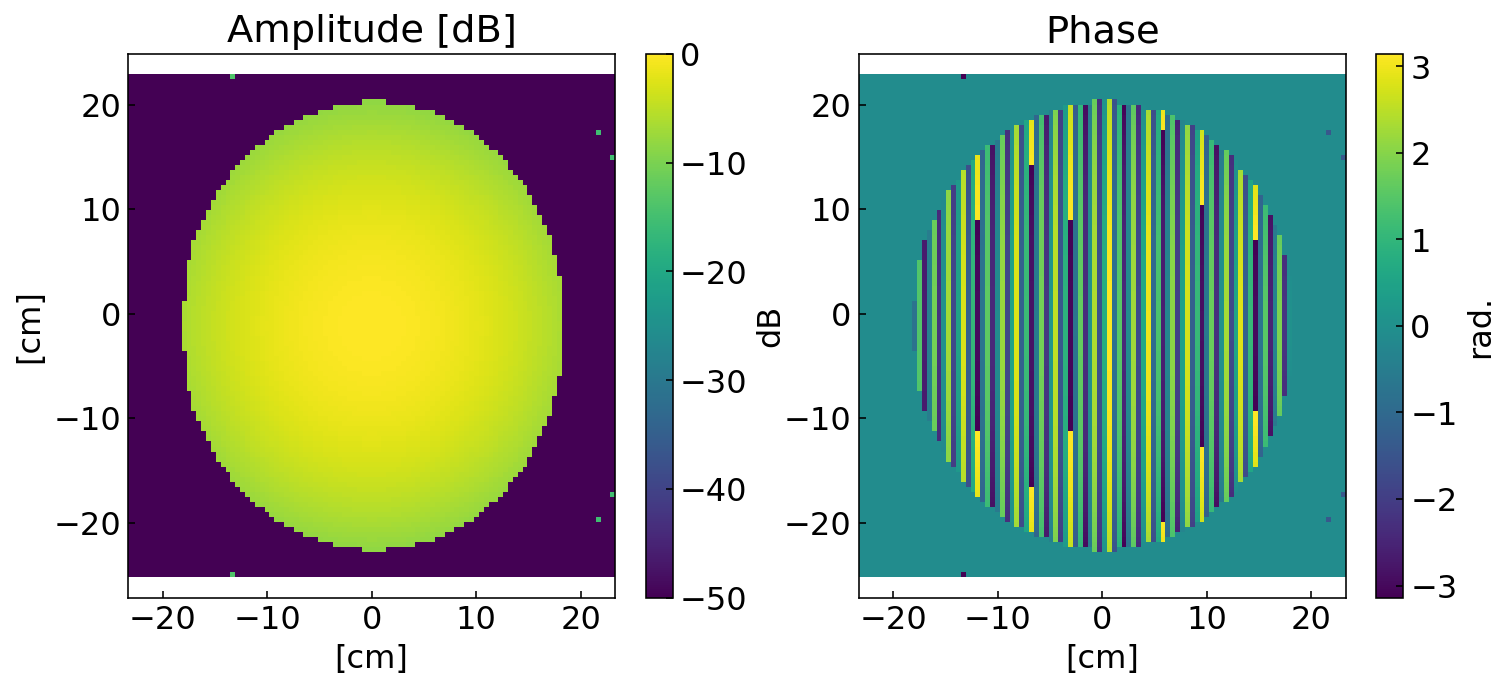

In [22]:
# Define the complex beam from ray-trace outputs
noise = 1e-6  # signal-to-noise of holography setup
a_sim /= np.max(abs(a_sim))
a_sim = a_sim + noise
beam_sim = (a_sim / np.max(a_sim)) * np.exp(complex(0, 1) * p_sim)

# Define the dimmensions of the waveguide
apert1 = 1  # [cm]
apert2 = 1  # [cm]

# Convolve beam
x, y, beam_conv = opt_analyze.beam_convolve(
    np.real(x_sim) / 1e1, np.real(y_sim) / 1e1, beam_sim, apert1, apert2, 0
)

plt.figure(figsize = (12,5))
plt.subplot(121)
plt.pcolormesh(x, y, 20 * np.log10(abs(beam_sim) / np.max(abs(beam_sim))), vmin=-50,shading = 'auto')
plt.colorbar(label = 'dB')
plt.axis("equal")
plt.title("Amplitude [dB]")
plt.xlabel("[cm]")
plt.ylabel("[cm]")

plt.subplot(122)
plt.pcolormesh(x, y, np.arctan2(np.imag(beam_sim),np.real(beam_sim)),shading = 'auto')
plt.colorbar(label = 'rad.')
plt.axis("equal")
plt.title("Phase")
plt.xlabel("[cm]")

plt.show()